In [1]:
import intake
import os
import numpy as np
import xarray as xr
import dask.array as da
import pandas as pd
import glob
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors


def setup_matplotlib(font_size=15):
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=font_size, labelsize=font_size)
    plt.rc('xtick', labelsize=font_size)
    plt.rc('ytick', labelsize=font_size)
    plt.rc('legend', fontsize=font_size)
setup_matplotlib()
SIZE = 15

In [2]:
#the data is downloaded in the same way as the wvmr in the notebook "process_wvmr_profiles.ipynb"
RH = xr.open_dataset('./../data/RH.nc')['rh']
start_time = np.datetime64('2020-01-12T00:00:00')
end_time   = np.datetime64('2020-02-28T23:00:00')
windspeed = xr.open_dataset('./../data/windspeed_eurec4a.nc')['wind_speed']
windspeed_avg = windspeed.sel(range = 1000, method = 'nearest').mean(dim = 'time')

clouds = np.loadtxt('./../data/processed_data/cloud_borders_2020.txt', delimiter=',', dtype='object') 
clouds[:, 0] = np.array(clouds[:, 0], dtype='datetime64[s]')
clouds[:, 1] = np.array(clouds[:, 1], dtype='datetime64[s]')
clouds[:, 2] = np.array(clouds[:, 2], dtype='float64')
clouds[:, 3] = np.array(clouds[:, 3], dtype='float64')
clouds[:, 4] = np.array(clouds[:, 4], dtype='float64')
clouds[:, 5] = np.array(clouds[:, 5], dtype='float64')

min_depth_shallow = 100
max_depth_shallow = 700
min_depth_deep = 700
max_depth_deep = 2500

clouds_time = clouds[(clouds[:, 0] >= start_time) & (clouds[:, 0] <= end_time)]


## Start with loading the data to plot the 2D anomaly profiles

We load data, compute the anomaly 2D profiles and plot them

In [3]:
def two_d_composite_anomaly(RH, clouds):
    """
    This function computes anomaly profiles of RH for all clouds.

    Inputs:
    - RH: values of relative humidity (coming from the LiDAR
    - clouds: array of clouds with their characteristics

    Outputs:
    RH_combined_before, RH_combined_after: profiles of RH anomalies with height both up- and downwind from clouds

    """
    
    delta_time = np.timedelta64(60, 'm')  # time we look before and after the cloud

    window_size = 4 #window chosen to interpolate the data (to fill the gaps)

    #lists to store the characteristics of clouds
    RH_before_arrays = []
    RH_after_arrays = []
    cloud_length = []
    cloud_bottom = []
    cloud_top = []
    cloud_mid = []
    cloud_depth = []


    # Replace zeros with NaNs using the mask
    mask_zeros = RH == 0
    RH = RH.where(~mask_zeros, np.nan)

    #We iterate over each cloud, to extract its anomaly profiles, then we will store it in an xarray
    for cloud_index, cloud_times in enumerate(clouds):
        try:

            #we define the times we select, both before and after the cloud
            start_time = np.datetime64(cloud_times[0])
            end_time = np.datetime64(cloud_times[1])
            cloud_bottom_i = cloud_times[3]
            cloud_top_i = cloud_times[4]
            altitude_mid_i = cloud_times[5]
            cloud_depth_i = cloud_top_i - cloud_bottom_i

            timedelta_before = start_time - delta_time
            timedelta_after = end_time + delta_time

            RH_mean = RH.sel(time=slice(timedelta_before, timedelta_after)).mean(dim='time')
            RH_before = RH.sel(time=slice(timedelta_before, start_time))

            # Subtract the mean profile from the original RH_before array
            RH_before = RH_before - RH_mean

            #we only took at hieghts of clouds (+-50m to be sure that we include everything)
            RH_before = RH_before.sel(alt=slice(cloud_bottom_i - 50, cloud_top_i + 50))

            RH_before['time'] = np.round(np.abs((RH_before.time - start_time) / np.timedelta64(1, 's')))
            RH_filled = RH_before.interpolate_na(dim='alt', method='linear', limit=None)

            # Interpolate along the time and altitude dimension
            start_time = RH_filled.time[0]
            new_time = np.arange(0, 60 * 60, 4)
            RH_interpolated = RH_filled.interp(time=new_time)
            # print(RH_interpolated)
            RH_interpolated['alt'] = (np.abs((RH_before.alt - RH_interpolated.alt.min()) / (RH_interpolated.alt.max() - RH_interpolated.alt.min())))

            new_alt = np.arange(0, 1, 0.01)
            RH_interpolated_alt = RH_interpolated.interp(alt=new_alt)
            RH_interpolated_alt = RH_interpolated_alt.rolling(time=window_size, center=True).mean()
            RH_before_arrays.append(RH_interpolated_alt)

            
            # We repeat the same with upwind, i.e., after the cloud
            RH_after = RH.sel(time=slice(end_time, timedelta_after))
            # mean_profile = RH_after.mean(dim='time')
            RH_after = RH_after - RH_mean
            RH_after = RH_after.sel(alt=slice(cloud_bottom_i - 50, cloud_top_i + 50))

            RH_after['time'] = np.round(np.abs((RH_after.time - end_time) / np.timedelta64(1, 's')))
            RH_filled = RH_after.interpolate_na(dim='alt', method='linear', limit=None)

            # Interpolate along the time and altitude dimension
            start_time = RH_filled.time[0]
            new_time = np.arange(0, 60 * 60, 4)
            RH_interpolated = RH_filled.interp(time=new_time)
            RH_interpolated['alt'] = (np.abs((RH_after.alt - RH_interpolated.alt.min()) / (RH_interpolated.alt.max() - RH_interpolated.alt.min())))

            new_alt = np.arange(0, 1, 0.01)
            RH_interpolated_alt = RH_interpolated.interp(alt=new_alt)
            RH_interpolated_alt = RH_interpolated_alt.rolling(time=window_size, center=True).mean()
            RH_after_arrays.append(RH_interpolated_alt)


            #include the cloud characteristics to the profiles of this cloud
            cloud_length.append(clouds[cloud_index][2])
            cloud_bottom.append(cloud_bottom_i)
            cloud_top.append(cloud_top_i)
            cloud_mid.append(altitude_mid_i)
            cloud_depth.append(cloud_depth_i)

        except:
            continue

    # Concatenate the xarrays along a new dimension
    RH_combined_before = xr.concat(RH_before_arrays, dim='cloud')
    RH_combined_before.coords['cloud_length'] = ('cloud', cloud_length)
    RH_combined_before.coords['cloud_bottom'] = ('cloud', cloud_bottom)
    RH_combined_before.coords['cloud_mid'] = ('cloud', cloud_mid)
    RH_combined_before.coords['cloud_top'] = ('cloud', cloud_top)
    RH_combined_before.coords['cloud_depth'] = ('cloud', cloud_depth)

    RH_combined_after = xr.concat(RH_after_arrays, dim='cloud')
    RH_combined_after.coords['cloud_length'] = ('cloud', cloud_length)
    RH_combined_after.coords['cloud_bottom'] = ('cloud', cloud_bottom)
    RH_combined_after.coords['cloud_mid'] = ('cloud', cloud_mid)
    RH_combined_after.coords['cloud_top'] = ('cloud', cloud_top)
    RH_combined_after.coords['cloud_depth'] = ('cloud', cloud_depth)

    return RH_combined_before, RH_combined_after


In [4]:
%%time
RH_before, RH_after = two_d_composite_anomaly(RH,clouds_time)

CPU times: user 6min 9s, sys: 11.8 s, total: 6min 21s
Wall time: 6min 23s


In [5]:
# we convert times into distances with the following function. It has already been defined in the "process_LW_BC_data.ipynb" notebook:
def lw_down_clouds_dist_approx(LW_down_clouds, windspeed_avg):
    """
    Converts the time dimension into distance using the average windspeed. This approximation is justified since the focus is not on a few meters of 
    precision. This average windspeed is enough.
    """
    # Calculate distance from cloud based on time and windspeed
    distance_from_cloud = LW_down_clouds.time * windspeed_avg.item()
    
    # Rename the 'time' dimension to 'distance_from_cloud'
    LW_down_clouds = LW_down_clouds.rename({'time': 'distance_from_cloud'})
    
    # Create a new coordinate 'distance' using the calculated distances
    LW_down_clouds.coords['distance'] = ('distance_from_cloud', distance_from_cloud.data)
    
    # Replace the existing 'time' coordinate with the new 'distance' coordinate
    LW_down_clouds = LW_down_clouds.swap_dims({'distance_from_cloud': 'distance'})
    
    # Add units attribute to the distance coordinate
    LW_down_clouds.coords['distance'].attrs['units'] = 'm'
    
    return LW_down_clouds


In [6]:
RH_before_dist =  lw_down_clouds_dist_approx(RH_before, windspeed_avg)
RH_after_dist = lw_down_clouds_dist_approx(RH_after, windspeed_avg)

In [7]:
RH_before_dist = RH_before_dist.rename('RH anomaly')
RH_after_dist = RH_after_dist.rename('RH anomaly')

In [8]:
#We separate the data into shallow clouds and deep ones
RH_before_dist_shallow = RH_before_dist.where((RH_before_dist.cloud_depth > min_depth_shallow) & (RH_before_dist.cloud_depth < max_depth_shallow), drop=True)
RH_after_dist_shallow = RH_after_dist.where((RH_after_dist.cloud_depth > min_depth_shallow) & (RH_after_dist.cloud_depth < max_depth_shallow), drop=True)

RH_before_dist_deep = RH_before_dist.where((RH_before_dist.cloud_depth > min_depth_deep) & (RH_before_dist.cloud_depth < max_depth_deep), drop=True)
RH_after_dist_deep = RH_after_dist.where((RH_after_dist.cloud_depth > min_depth_deep) & (RH_after_dist.cloud_depth < max_depth_deep), drop=True)


In [9]:
#In order to compare and plot all the clouds on the same plot, we rescale the height to the mean depth of clouds in each category:
def rescale_alt_coordinate(data_array, new_max):
    # Rescale the alt coordinate
    data_array = data_array.assign_coords(alt=data_array.alt * (new_max))
    return data_array

In [10]:
def discrete_cmap(base_cmap, N):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return mcolors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)

# Number of discrete colors
N = 5
discrete_viridis = discrete_cmap('viridis', N)

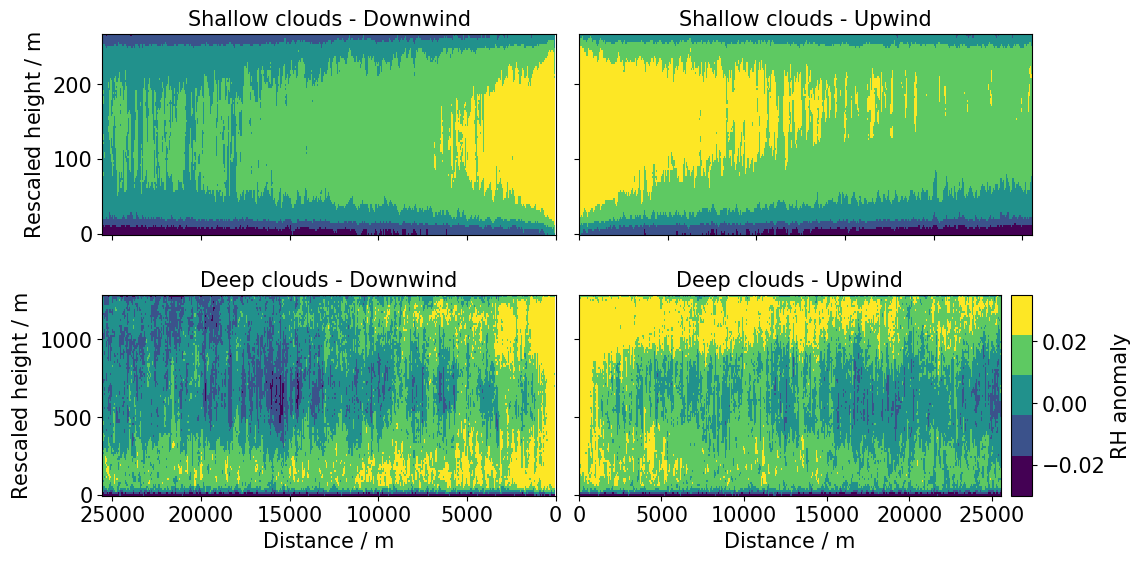

In [11]:
fig = plt.figure(figsize=(12, 6))

G = gridspec.GridSpec(2, 2, hspace=0.3)

min_cbar = -0.03
max_cbar = 0.035

cmap = plt.get_cmap('tab20c').reversed()

# Plot for shallow clouds - Downwind
ax1 = plt.subplot(G[0, 0])
im1 = rescale_alt_coordinate(RH_before_dist_shallow.mean(dim='cloud'), RH_before_dist_shallow.cloud_depth.mean()).plot(
    ax=ax1, x='distance', y='alt', vmin=min_cbar, vmax=max_cbar, add_colorbar=False, cmap=discrete_viridis)
ax1.invert_xaxis()
ax1.set_title('Shallow clouds - Downwind')
ax1.set_ylabel(r'Rescaled height / ${\rm m}$')
ax1.set_xlabel('')
ax1.set_xticklabels([])

# Plot for shallow clouds - Upwind
ax2 = plt.subplot(G[0, 1])
im2 = rescale_alt_coordinate(RH_after_dist_shallow.mean(dim='cloud'), RH_after_dist_shallow.cloud_depth.mean()).plot(
    ax=ax2, x='distance', y='alt', vmin=min_cbar, vmax=max_cbar, add_colorbar=False, cmap=discrete_viridis)
ax2.set_title('Shallow clouds - Upwind')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Plot for deep clouds - Downwind
ax3 = plt.subplot(G[1, 0])
im3 = rescale_alt_coordinate(RH_before_dist_deep.mean(dim='cloud'), RH_before_dist_deep.cloud_depth.mean()).plot(
    ax=ax3, x='distance', y='alt', vmin=min_cbar, vmax=max_cbar, add_colorbar=False, cmap=discrete_viridis)
ax3.invert_xaxis()
ax3.set_title('Deep clouds - Downwind')
ax3.set_ylabel(r'Rescaled height / ${\rm m}$')
ax3.set_xlabel('Distance / m')

# Plot for deep clouds - Upwind
ax4 = plt.subplot(G[1, 1])
im4 = rescale_alt_coordinate(RH_after_dist_deep.mean(dim='cloud'), RH_after_dist_deep.cloud_depth.mean()).plot(
    ax=ax4, x='distance', y='alt', vmin=min_cbar, vmax=max_cbar, add_colorbar=False, cmap=discrete_viridis)
ax4.set_title('Deep clouds - Upwind')
ax4.set_ylabel('')
ax4.set_xlabel('Distance / m')
ax4.set_yticklabels([])

# Create a colorbar axis next to the main axes
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im4, cax=cax, orientation='vertical', label='RH anomaly')

plt.subplots_adjust(wspace=0.05)

plt.savefig('./../Figures/RH_anomalies/RH_composite_2D_anomaly_comp_size.png', bbox_inches='tight')
plt.show()


## Then we plot the RH 1D anomalies profiles as a function of distance for the three defined heights

Here we plot the RH 1D anomalies profiles, that have computed before but we separate the three heights: SCL, CL, TCL

In [12]:
dataset_shallow = xr.open_dataset('./../data/processed_data/1d_anomalies/clouds_diff_shallow.nc')

# Access individual arrays (variables) by their names
RH_combined_before_bottom_shallow = dataset_shallow['RH_combined_before_bottom']
RH_combined_before_mid_shallow = dataset_shallow['RH_combined_before_mid']
RH_combined_before_top_shallow = dataset_shallow['RH_combined_before_top']
RH_combined_after_bottom_shallow = dataset_shallow['RH_combined_after_bottom']
RH_combined_after_mid_shallow = dataset_shallow['RH_combined_after_mid']
RH_combined_after_top_shallow = dataset_shallow['RH_combined_after_top']

dataset_deep = xr.open_dataset('./../data/processed_data/1d_anomalies/clouds_diff_deep.nc')

# Access individual arrays (variables) by their names
RH_combined_before_bottom_deep = dataset_deep['RH_combined_before_bottom']
RH_combined_before_mid_deep = dataset_deep['RH_combined_before_mid']
RH_combined_before_top_deep = dataset_deep['RH_combined_before_top']
RH_combined_after_bottom_deep = dataset_deep['RH_combined_after_bottom']
RH_combined_after_mid_deep = dataset_deep['RH_combined_after_mid']
RH_combined_after_top_deep = dataset_deep['RH_combined_after_top']


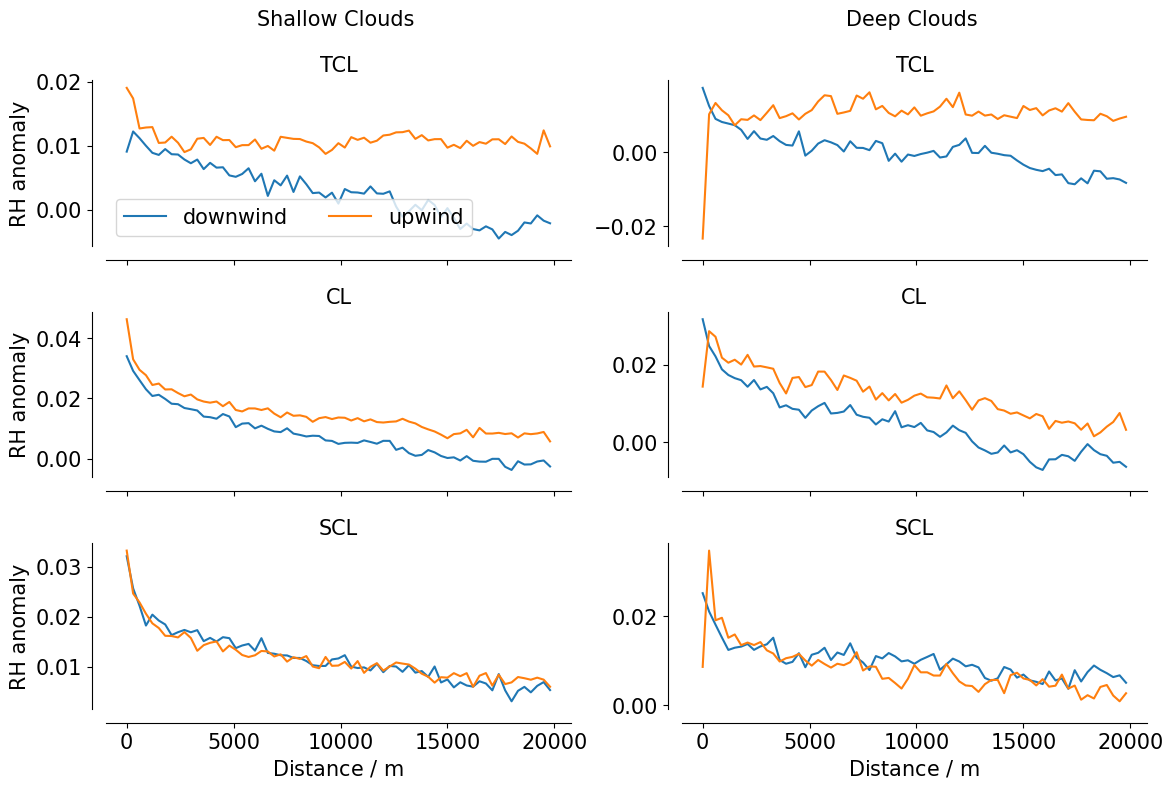

In [13]:
bin_edges = np.arange(0, 20000, 300)

#define lists to stores the profiles both for shallow and deep clouds
up_down_profiles_shallow = {}
up_down_profiles_deep = {}

#these are the 6 different xarrays: for 2 sides (up and downwind) and for the three heights
array_names = [
    'RH_combined_before_bottom', 'RH_combined_before_mid', 'RH_combined_before_top',
    'RH_combined_after_bottom', 'RH_combined_after_mid', 'RH_combined_after_top'
]

def plot_up_down_profiles(array, bin_edges):
    # Average over 'cloud' dimension
    averaged_cloud = array.mean(dim='cloud')
    
    # Digitize the distance coordinates to find out which bin each distance falls into
    distance = averaged_cloud['distance']
    bins = np.digitize(distance, bin_edges) - 1  # Subtract 1 to make the bin indices 0-based

    # Create a new DataArray with the bin indices as a coordinate
    binned = xr.DataArray(bins, coords=[distance], name='binned')

    # Add this new coordinate to the original DataArray
    averaged_cloud = averaged_cloud.assign_coords(binned=binned)

    # Group by the new binned coordinate and calculate the mean for each group
    averaged_binned = averaged_cloud.groupby('binned').mean()

    return averaged_binned

# Loop through each array name, process it, and store it in the dictionaries
for name in array_names:
    up_down_profiles_shallow[name] = plot_up_down_profiles(dataset_shallow[name], bin_edges)
    up_down_profiles_deep[name] = plot_up_down_profiles(dataset_deep[name], bin_edges)

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Plotting for shallow data (left column)
titles = ['TCL', 'CL', 'SCL']
for i, layer in enumerate(['top', 'mid', 'bottom']):
    axes[i, 0].set_title(titles[i])
    for name in [f'RH_combined_before_{layer}', f'RH_combined_after_{layer}']:
        axes[i, 0].plot(bin_edges, up_down_profiles_shallow[name])
    if i == 0:  # Add legend only to the top row first column
        axes[i, 0].legend(['downwind', 'upwind'], loc = 'lower left', ncol = 2)
    axes[i, 0].spines.right.set_visible(False)
    axes[i, 0].spines.top.set_visible(False)
    axes[i, 0].set_xlabel(r'Distance / ${\rm m}$')
    axes[i, 0].set_ylabel('RH anomaly')
    axes[i, 0].spines[["left", "bottom"]].set_position(("outward", 10))
    #axes[i, 0].set_ylim(0.15,0.23)
    if i < 2:  # Hide x-axis labels for all but the bottom row
        axes[i, 0].set_xticklabels([])
        axes[i, 0].set_xlabel('')


# Plotting for deep data (right column)
for i, layer in enumerate(['top', 'mid', 'bottom']):
    axes[i, 1].set_title(titles[i])
    for name in [f'RH_combined_before_{layer}', f'RH_combined_after_{layer}']:
        axes[i, 1].plot(bin_edges, up_down_profiles_deep[name])
    axes[i, 1].spines.right.set_visible(False)
    axes[i, 1].spines.top.set_visible(False)
    axes[i, 1].set_ylabel('')
    axes[i, 1].set_xlabel(r'Distance / ${\rm m}$')
    axes[i, 1].spines[["left", "bottom"]].set_position(("outward", 10))
    if i < 2:  # Hide x-axis labels for all but the bottom row
        axes[i, 1].set_xticklabels([])
        axes[i, 1].set_xlabel('')

fig.text(0.29, 0.97, 'Shallow Clouds', ha='center', fontsize=15)
fig.text(0.77, 0.97, 'Deep Clouds', ha='center', fontsize=15)


#plt.suptitle('Comparison of RH anomaly profiles up/downwind of clouds')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('./../Figures/RH_anomalies/RH_profiles_up_down_all.png', bbox_inches='tight')
plt.show()


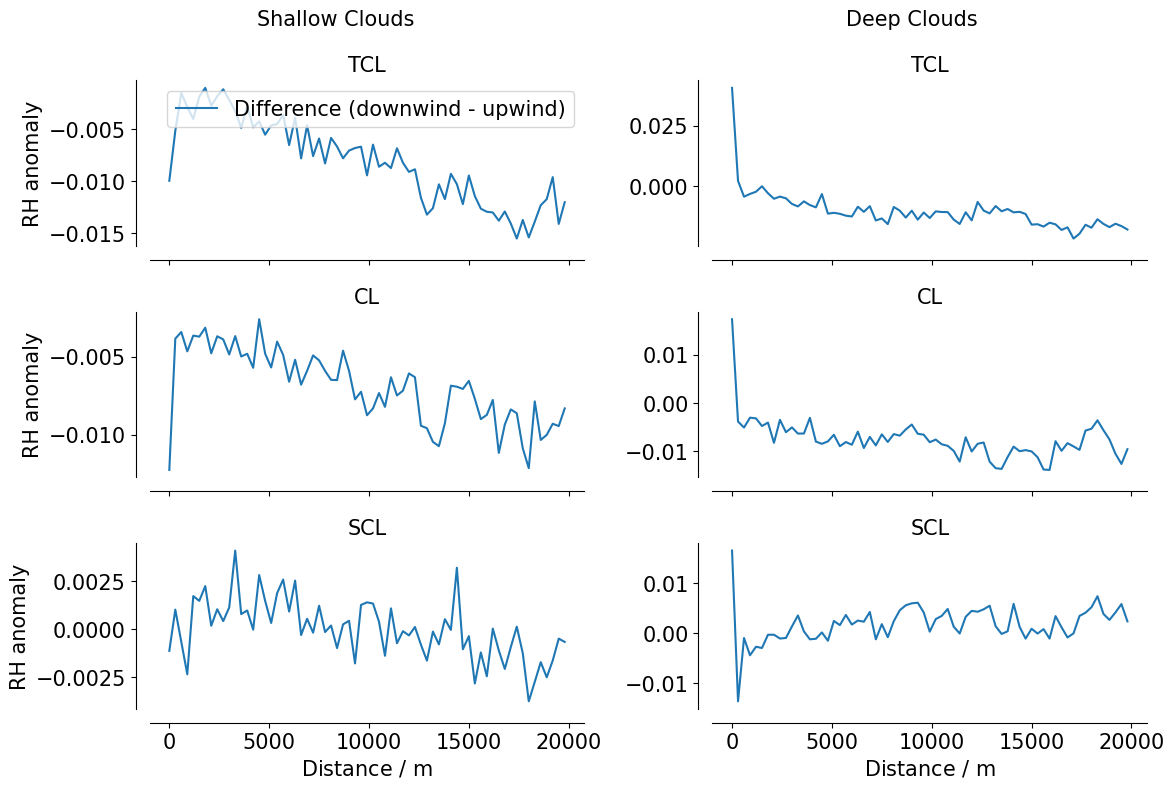

In [14]:
# This code does the same plot, but only plotting the differences between the upwind part and the downwind part

up_down_profiles_shallow = {}
up_down_profiles_deep = {}

# Loop through each array name, process it, and store it in the dictionaries
for name in array_names:
    up_down_profiles_shallow[name] = plot_up_down_profiles(dataset_shallow[name], bin_edges)
    up_down_profiles_deep[name] = plot_up_down_profiles(dataset_deep[name], bin_edges)

# Calculate differences for shallow and deep datasets
differences_shallow = {
    'bottom': up_down_profiles_shallow['RH_combined_before_bottom'] - up_down_profiles_shallow['RH_combined_after_bottom'],
    'mid': up_down_profiles_shallow['RH_combined_before_mid'] - up_down_profiles_shallow['RH_combined_after_mid'],
    'top': up_down_profiles_shallow['RH_combined_before_top'] - up_down_profiles_shallow['RH_combined_after_top']
}

differences_deep = {
    'bottom': up_down_profiles_deep['RH_combined_before_bottom'] - up_down_profiles_deep['RH_combined_after_bottom'],
    'mid': up_down_profiles_deep['RH_combined_before_mid'] - up_down_profiles_deep['RH_combined_after_mid'],
    'top': up_down_profiles_deep['RH_combined_before_top'] - up_down_profiles_deep['RH_combined_after_top']
}

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Plotting for shallow data (left column)
titles = ['TCL', 'CL', 'SCL']
for i, layer in enumerate(['top', 'mid', 'bottom']):
    axes[i, 0].set_title(titles[i])
    axes[i, 0].plot(bin_edges, differences_shallow[layer])
    if i == 0:  # Add legend only to the top row first column
        axes[i, 0].legend(['Difference (downwind - upwind)'])
    axes[i, 0].spines.right.set_visible(False)
    axes[i, 0].spines.top.set_visible(False)
    axes[i, 0].set_xlabel(r'Distance / ${\rm m}$')
    axes[i, 0].set_ylabel('RH anomaly')
    axes[i, 0].spines[["left", "bottom"]].set_position(("outward", 10))
    #axes[i, 0].set_ylim(-0.028,0.012)
    if i < 2:  # Hide x-axis labels for all but the bottom row
        axes[i, 0].set_xticklabels([])
        axes[i, 0].set_xlabel('')

# Plotting for deep data (right column)
for i, layer in enumerate(['top', 'mid', 'bottom']):
    axes[i, 1].set_title(titles[i])
    axes[i, 1].plot(bin_edges, differences_deep[layer])
    axes[i, 1].spines.right.set_visible(False)
    axes[i, 1].spines.top.set_visible(False)
    axes[i, 1].set_xlabel(r'Distance / ${\rm m}$')
    axes[i, 1].set_ylabel('')
    axes[i, 1].spines[["left", "bottom"]].set_position(("outward", 10))
    #axes[i, 1].set_ylim(-0.075,0.04)
    if i < 2:  # Hide x-axis labels for all but the bottom row
        axes[i, 1].set_xticklabels([])
        axes[i, 1].set_xlabel('')


fig.text(0.29, 0.97, 'Shallow Clouds', ha='center', fontsize=15)
fig.text(0.77, 0.97, 'Deep Clouds', ha='center', fontsize=15)


#plt.suptitle('Difference of RH anomaly profiles (downwind - upwind) of clouds (Shallow vs Deep)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('./../Figures/RH_anomalies/RH_profiles_up_down_diff_all.png', bbox_inches='tight')
plt.show()
